In [1]:
from typing import Dict
import os
import cv2
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from clustering.model import MobilenetV3, Resnet18
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from clustering.config import *

## 1. Các thao tác hỗ trợ

In [2]:
# Transform the image, so it becomes readable with the model
transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

def extract_features(image_path: str, feature_extractor: nn.Module):
    image = cv2.imread(image_path)
    image = transformer(image)
    image = image.reshape(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    image = image.to(device)
    with torch.no_grad():
        feature = feature_extractor(image)
    # convert to nparray and reshape it
    feature = feature.cpu().detach().numpy().reshape(-1)
    return feature

In [3]:
import shutil

def gen_cluster_result(dst_folder: str, clustering_output: list):
    if os.path.exists(dst_folder):
        os.remove(dst_folder)
    else:
        os.mkdir(dst_folder)

    for id in range(len(clustering_output)):
        folder = os.path.join(dst_folder, str(id))
        if not os.path.exists(folder):
            os.mkdir(folder)
        for path in clustering_output[id]:
            name = path.split('\\')[1]
            shutil.copy(path, os.path.join(folder, name))

In [38]:
import json

def save_output(clustering_output: list, output_path: str):
    data_dict = {}
    for cluster_id, cluster in enumerate(clustering_output):
        data_dict[cluster_id] = cluster
    with open(output_path, "w") as f:
        json.dump(data_dict, f)

## 2. Thử nghiệm với MobileNetV3

### 2.1. Feature extraction

In [4]:
feature_extractor = MobilenetV3(option='large', pretrained=True)
feature_extractor.to(device)

MobilenetV3(
  (model): MobileNetV3(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): ConvB

Thử với 1 ảnh:

In [5]:
base_path = 'data/personal_new_pill/image'
image_name = 'VAIPE_P_0_0_0.jpg'
path = os.path.join(base_path, image_name)
features = extract_features(path, feature_extractor)
print(features.shape)

(1280,)


In [6]:
features

array([-0.05846998, -0.15309592, -0.20957772, ..., -0.04864265,
       -0.20833182, -0.25248948], dtype=float32)

Rút trích đặc trưng của toàn bộ ảnh + PCA:

In [7]:
image_src = 'data/personal_new_pill/image'
image_paths = np.array([os.path.join(image_src, file) for file in os.listdir(image_src)])

# Feature extraction
data = {}
for path in image_paths:
    data[path] = extract_features(path, feature_extractor)
features = [feature for feature in data.values()]

In [75]:
# N_COMP = 500
# pca = PCA(n_components=N_COMP)

# Giữ lại 95% phương sai
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(features)
features_pca = pca.transform(features)

In [76]:
features_pca.shape

(32828, 494)

In [77]:
N_COMP = 494

### 2.2. DBSCAN

#### 2.2.1. Tìm giá trị cho `minPts` và `epsilon`

Tham khảo từ https://phamdinhkhanh.github.io/deepai-book/ch_ml/index_DBSCAN.html

`minPTS` ít nhất là `2 * dim(input)`

In [78]:
MINPTS = 2 * N_COMP + 1
MINPTS

989

Phương pháp biểu đồ `Elbow` để tìm `epsilon`.

Text(0.5, 0, 'Indice')

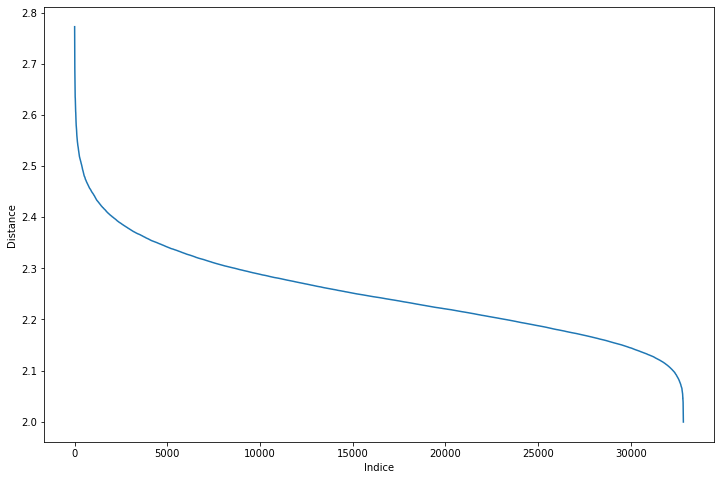

In [79]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = MINPTS - 1

nbrs = NearestNeighbors(n_neighbors=neighbors).fit(features_pca)

# Ma trận khoảng cách distances: (N, k) --> k hàng xóm gần nhất của mỗi "điểm"
distances, indices = nbrs.kneighbors(features_pca)

# Lấy ra khoảng cách xa nhất từ phạm vi hàng xóm của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1, len(distance_desc) + 1)), distance_desc)
plt.ylabel('Distance')
plt.xlabel('Indice')


`epsilon = 2.1` (?)

In [80]:
THRES = 2.1

In [81]:
dbscan = DBSCAN(eps=THRES, min_samples=MINPTS)
dbscan_output = dbscan.fit_predict(features_pca)
dbscan_output

array([-1,  0,  0, ..., -1,  0,  0], dtype=int64)

In [82]:
print(min(dbscan_output), ' ; ', max(dbscan_output))
# -1 means noise

-1  ;  0


Kết quả này nhìn chấm hỏi quá :)) Nó gom hết vào 1 cụm rồi

In [ ]:
dbcan_output_path = []
# ...

#### 2.3. KMeans

Tìm `K` phù hợp bằng phương pháp biểu đồ `Elbow`: xét trong range từ 107 tới 120

In [83]:
cost =[]
k_range = range(107, 120)

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features_pca)
    cost.append(kmeans.inertia_)

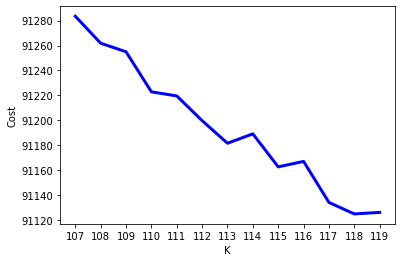

In [84]:
plt.plot(range(len(k_range)), cost, color ='b', linewidth ='3')
plt.xlabel("K")
plt.ylabel("Cost")
plt.xticks(range(len(k_range)), k_range)
plt.show()

Thử `K = 117`

In [85]:
K = 117
kmeans = KMeans(n_clusters=K)
kmean_output = kmeans.fit_predict(features_pca)
kmean_output

array([ 16,  17,  51, ...,  81, 102, 113])

In [86]:
kmean_output_paths = []
for id in range(0, K):
    cluster_paths = image_paths[kmean_output == id]
    kmean_output_paths.append(list(cluster_paths))

In [88]:
save_output(clustering_output=kmean_output_paths, output_path='clustering/personal_kmean_output.json')

In [89]:
gen_cluster_result(dst_folder='clustering/personal_kmean_output', clustering_output=kmean_output_paths)